In [1]:
'''
This file was provided by mentor for practicing and understanding ML concepts
'''

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

#These imports are used to help display the results, but have no direct impact on training the model.
from tqdm import tqdm #Utility for displaying progress bar while training
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output

training_data = datasets.MNIST(
    root="data", #folder name to either look for or save the dataset in
    train=True, #Training dataset
    download=True, #Download the dataset if it was not found in the root folder.
    transform=ToTensor() #Loads the values in as Tensors with the values modified to the range [0,1] for processing
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

#Hyperparameters: The parameters modified to 
learning_rate = .001 # also known as alpha
epochs = 10 # Number of times the model is trained on the entire dataset
batch_size = 64 # Number of inputs used to train the model per batch

#DataLoaders are used to iterate over the datasets.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

class NeuralNetwork(nn.Module): #Inherits from the nn.Module
    def __init__(self): #Constructor
        super(NeuralNetwork, self).__init__() #ALWAYS call the parent constructor when creating a Neural Network.
        self.flatten = nn.Flatten() # Transforms the 28x28 input image into a flat 784 row.
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), #Fully connected layer without modification
            nn.ReLU(), #Rectified Linear Unit: Performs a max(0, x) operation on the inputs.
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    # NOTE: THIS METHOD IS NEVER DIRECTLY CALLED. 
    # The usage of forward is implicitly called by calling the instance of the model on a given input.
    # Feed the input, x, through the previously defined layers in the Constructor.
    def forward(self, x): 
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [2]:
def train_loop(dataloader, model, loss_fn, optimizer, history_dict):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    
    for (X, y) in tqdm(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        #Metrics
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad() #Resets gradient calculations to prevent accumulation between batches & epochs.
        loss.backward() #Calculates gradient loss associated with each weight in the model.
        optimizer.step() #Updates the model's weights based on the loss, optimizer and learning rate.
        
    train_loss /= num_batches
    correct /= size
    # print(f"Train loss: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

    history_dict["training_loss"].append(train_loss)
    history_dict["training_accuracy"].append(correct)


def test_loop(dataloader, model, loss_fn, history_dict):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    history_dict["test_loss"].append(test_loss)
    history_dict["test_accuracy"].append(correct)

In [3]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
history_dict = {"training_loss": [], "training_accuracy": [], "test_loss": [], "test_accuracy": []}
import sys
for t in range(epochs):
    clear_output()
    if t != 0:
        print(f"training acc: {history_dict["training_accuracy"][-1]*100:>0.2f}%, test acc: {history_dict["test_accuracy"][-1]*100:>0.2f}%")
    print(f"Epoch {t+1} of {epochs}")
    train_loop(train_dataloader, model, loss_fn, optimizer, history_dict)
    test_loop(test_dataloader, model, loss_fn, history_dict)
    
print("Done!")

training acc: 81.18%, test acc: 82.60%
Epoch 10 of 10


100%|██████████| 938/938 [00:21<00:00, 44.28it/s]


Done!


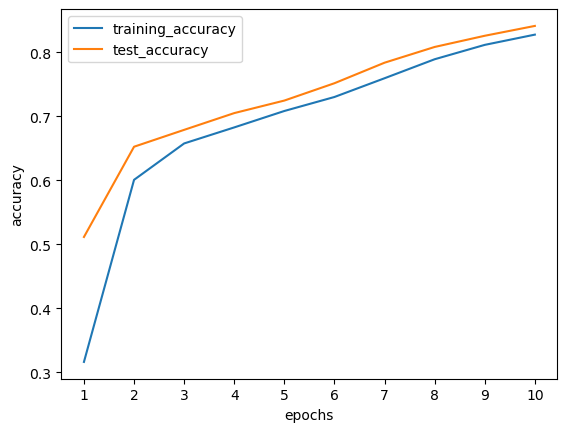

In [4]:
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xticks(np.arange(epochs, dtype=int) + 1)
plt.plot(np.arange(epochs, dtype=int) + 1, history_dict["training_accuracy"], label="training_accuracy")
plt.plot(np.arange(epochs, dtype=int) + 1, history_dict["test_accuracy"], label="test_accuracy")
plt.legend(loc="upper left")

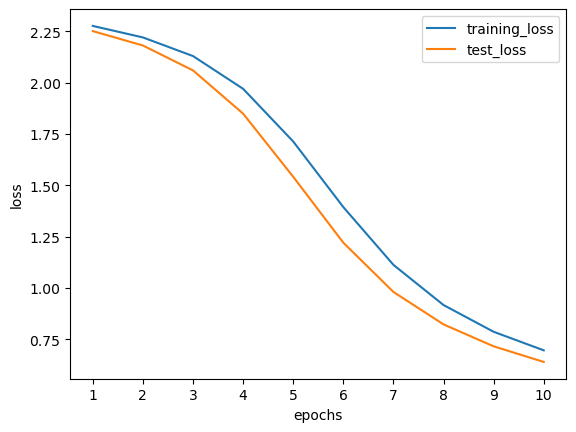

In [5]:
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xticks(np.arange(epochs, dtype=int) + 1)
plt.plot(np.arange(epochs, dtype=int) + 1, history_dict["training_loss"], label="training_loss")
plt.plot(np.arange(epochs, dtype=int) + 1, history_dict["test_loss"], label="test_loss")
plt.legend(loc="upper right")